# Exemplo 08: Grafo de Comunidade
## Karate Club do Zachary

Community Graph is a model to represent relationship of nodes in a graph, such people interaction, people interest etc. 

The Girvan–Newman algorithm is a hierarchical method used to detect communities in complex systems. The Girvan–Newman algorithm detects communities by progressively removing edges from the original network. The remained connected components are the communities. Instead of trying to construct a measure which shows the edges edges are the most central to communities, the Girvan–Newman algorithm focuses on edges that are most likely "between" communities.

The Spectral Clustering algorithm make use of the spectrum (eigenvalues) of the similarity matrix of the data to perform a dimensionality reduction before clustering in fewer dimensions to identify the "communities". The similarity matrix is provided as an input and consists of a quantitative assessment of the relative similarity of each pair of points in the dataset.

## Zachary's Karate Club

A social network of a karate club was studied by Wayne W. Zachary for a period of three years from 1970 to 1972. The network captures 34 members of a karate club, documenting links between pairs of members who interacted outside the club. During the study a conflict arose between the administrator "John A" and instructor "Mr. Hi" (pseudonyms), which led to the split of the club into two. Half of the members formed a new club around Mr. Hi; members from the other part found a new instructor or gave up karate. Based on collected data Zachary correctly assigned all but one member of the club to the groups they actually joined after the split.

The standard 78-edge network data set for Zachary's karate club is publicly available on the internet. The data can be summarized as list of integer pairs. Each integer represents one karate club member and a pair indicates the two members interacted. Zachary's Karate Club was used in Girvan Newman paper and is a reference for community studies.

## References

Girvan M. and Newman M. E. J. (2002). "Community structure in social and biological networks". Proc. Natl. Acad. Sci. USA 99, 7821–7826.

William Donath and Alan Hoffman (1972). "Algorithms for partitioning of graphs and computer logic based on eigenvectors of connections matrices". IBM Technical Disclosure Bulletin.

Zachary, W. W. (1977). "An Information Flow Model for Conflict and Fission in Small Groups". Journal of Anthropological Research. 33 (4): 452–473. JSTOR.

In [1]:
# Start Spark configuration
import findspark
findspark.init()

In [2]:
# Load libraries
import pyspark
from pyspark.sql import SparkSession

import time
start_time = time.time()

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
# import pyarrow

import community
from sklearn.cluster import SpectralClustering
from sklearn import metrics

data_path='./data/'

%matplotlib inline

In [3]:
# Create Spark Session
sparkSession = SparkSession.builder \
               .master("local[*]") \
               .appName("CommunityGraph") \
               .getOrCreate()

# Enable Arrow-based columnar data transfers
#sparkSession.conf.set("spark.sql.execution.arrow.enabled", "true")

## Reading Data

In [4]:
#Extrai dados de Karate CSV para Dataframe Spark
karate = sparkSession.read.format("csv").options(header='true',inferschema='true'). \
         load(data_path+"karate_edges.csv")

#youtube.dtypes
karate.show(5)

+----+---+
|from| to|
+----+---+
|   1|  2|
|   1|  3|
|   2|  3|
|   1|  4|
|   2|  4|
+----+---+
only showing top 5 rows



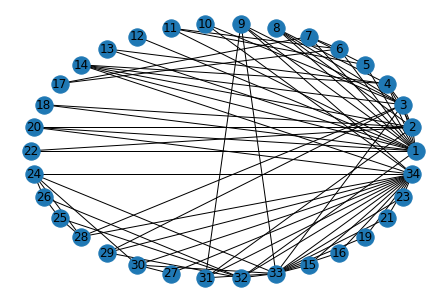

Number of nodes = 34
Number of edges = 78


In [5]:
# Extrair campos para definir os arestas do grafo e converter para Dataframe Pandas
edge = karate.select("from","to").toPandas()

#G = nx.karate_club_graph()
G = nx.from_pandas_edgelist(edge,source="from",target="to",create_using=nx.Graph())

# Define node position in graph
pos = nx.spring_layout(G) 

nx.draw_circular(G, with_labels=True)
plt.show()

print("Number of nodes =",G.number_of_nodes())
print("Number of edges =",G.number_of_edges())

## Girvan-Newman and Modularity

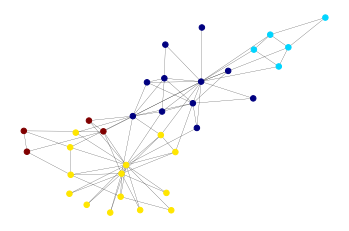

Modularity: 0.4151051939513477


In [6]:
# Partition using Girvan-Newman
part = community.best_partition(G)

# Calculate modularity
mod = community.modularity(part,G)

# Plot, color nodes using community structure
values = [part.get(node) for node in G.nodes()]
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('jet'), node_color=values, node_size=30, with_labels=False, width=0.2)
plt.axis('off')
plt.show()

print("Modularity:",mod)

## Spectral Clustering

Spectral Clustering: [0 6 7 5 0 3 3 5 1 7 0 0 5 5 3 6 6 6 4 2 2 2 7 4 4 6 2 1 1 1 1 1 1 1]


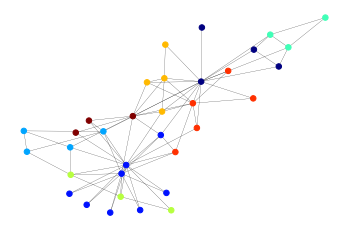

In [7]:
# Get adjacency-matrix as numpy-array
adj_mat = nx.to_numpy_matrix(G)

# Cluster
sc = SpectralClustering(affinity='precomputed', n_init=100, assign_labels='discretize')
sc.fit(adj_mat)

# Compare ground-truth and clustering-results
print('Spectral Clustering:', sc.labels_)

# Plot, color nodes using community
values = sc.labels_
nx.draw_networkx(G, pos=pos, cmap=plt.get_cmap('jet'), node_color=values, node_size=30, with_labels=False, width=0.2)
plt.axis('off')
plt.show()

In [8]:
sparkSession.stop()
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

--- Execution time: 11.885229587554932 seconds ---
